# Data Analysis for Network Security 101 (Solution)

This is the [Wildcard 400 of the 2019 Trendmicro CTF](https://ctf.trendmicro.com). It's a fun set of exercises! Before you read the solutions, try out the challenge first using the [questions kernel](https://www.kaggle.com/hawkcurry/data-analysis-for-network-security-101-questions)

## Introduction

You are a network security administrator for the medium sized business XYZcorp.  You often use network flow data to uncover anomalous security events.  This challenge provides some sample aggregated data on flows, and uses answers from the anomalous events to construct the flag.

Knowledge of network security or protocols is not required.  This challenge requires data stacking, slicing, and/or anomaly detection.

### Data
  - timestamp,src,dst,port,bytes
  - Internal hosts have IPs beginning with 12-14
  - External IPs include everything else

## Preprocessing

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gc

In [3]:
df = pd.read_csv(
    'gowiththeflow_20190826.csv',
    header = 0, 
    names= ['ts', 'src', 'dst', 'port', 'bytes']
)
df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'gowiththeflow_20190826.csv'

We create extra features to make it more convenient to do certain filters such as _"inbound traffic"_ and _"outbound traffic"_

In [ ]:
def is_internal(s):
    return s.str.startswith(('12.', '13.', '14.')) 

df['src_int'] = is_internal(df['src'])
df['dst_int'] = is_internal(df['dst'])

df['ts']      = pd.to_datetime(df.ts, unit='ms')
df['hour']    = df.ts.dt.hour.astype('uint8')
df['minute']  = df.ts.dt.minute.astype('uint8')
df['port']    = df['port'].astype('uint8')
df.head()

,ts,src,dst,port,bytes,src_int,dst_int,hour,minute
0,2020-01-06 16:00:00.005,16.79.101.100,12.48.65.39,92,11895,False,True,16,0
1,2020-01-06 16:00:00.007,18.43.118.103,14.51.30.86,27,898,False,True,16,0
2,2020-01-06 16:00:00.011,15.71.108.118,14.50.119.33,57,7496,False,True,16,0
3,2020-01-06 16:00:00.012,14.33.30.103,15.24.31.23,115,20979,True,False,16,0
4,2020-01-06 16:00:00.012,18.121.115.31,13.56.39.74,92,8620,False,True,16,0


We convert the `src` and `dst` as categorical to save on memory.

In [ ]:
all_ips = set(df['src'].unique()) | set(df['dst'].unique())
print('Unique src:', df['src'].nunique())
print('Unique dst:', df['dst'].nunique())
print('Total Unique IPs:', len(all_ips))

ip_type = pd.CategoricalDtype(categories=all_ips)
df['src'] = df['src'].astype(ip_type)
df['dst'] = df['dst'].astype(ip_type)
gc.collect()
df.info()

Unique src: 6171
Unique dst: 6005
Total Unique IPs: 6177
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105747729 entries, 0 to 105747728
Data columns (total 9 columns):
 #   Column   Dtype         
---  ------   -----         
 0   ts       datetime64[ns]
 1   src      category      
 2   dst      category      
 3   port     uint8         
 4   bytes    int64         
 5   src_int  bool          
 6   dst_int  bool          
 7   hour     uint8         
 8   minute   uint8         
dtypes: bool(2), category(2), datetime64[ns](1), int64(1), uint8(3)
memory usage: 2.5 GB


## Challenges

The data used here is highly synthetic, so it should be obvious when you get the _right_ answer. 

In [ ]:
blacklist_ips = []
answers = []

### Question 1: Discover Data Exfiltration 1

*Our intellectual property is leaving the building in large chunks. A machine inside is being used to send out all of our widget designs. One host is sending out much more data from the enterprise than the others. What is its IP?*

This is straightforward. We get the sources with the most outbound traffic in our network.

In [ ]:
src_bytes_out = df[df['src_int'] & ~df['dst_int']]\
  .groupby('src')\
  .bytes.sum()\
  .pipe(lambda x: x[x > 0])\
  .sort_values(ascending=False)

src_bytes_out.to_frame().head()

Text(0.5, 0, 'total outbound bytes')

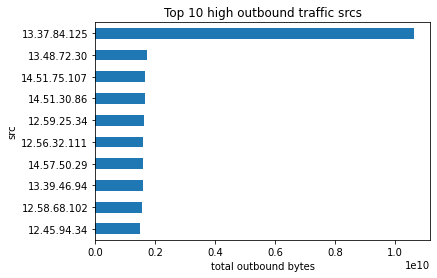

In [ ]:
src_bytes_out.head(10)\
    .sort_values()\
    .plot.barh(title='Top 10 high outbound traffic srcs')\
    .set_xlabel('total outbound bytes')

Text(10625497574, 100, '13.37.84.125')

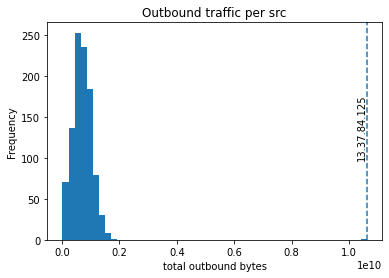

In [ ]:
ax = src_bytes_out\
  .plot.hist(bins=50, title='Outbound traffic per src')

ax.set_xlabel('total outbound bytes')
_ = ax.axvline(src_bytes_out.iloc[0], linestyle='--')
plt.text(src_bytes_out.iloc[0], 100, '13.37.84.125', rotation=90, horizontalalignment='right')

In [ ]:
blacklist_ips.append('13.37.84.125')
answers.append('13.37.84.125')

__ANSWER:__ 13.37.84.125

### Question 2: Discover Data Exfiltration 2

*Another attacker has a job scheduled that export the contents of our internal wiki. One host is sending out much more data during off hours from the enterprise than the others, different from the host in the Question 1. What is its IP?* 



We look for the `src` that sends much more data outbound during off hours. To do this we first have to identify which are the off hours. From the plot below, we see regular office hours are between 16:00 to 23:00. So we filter for 0:00 to 16:00.

Text(0, 0.5, 'Connection counts')

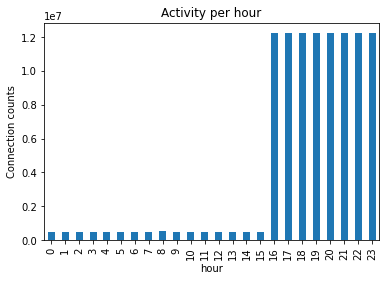

In [ ]:
df.groupby('hour').size()\
  .plot.bar(title='Activity per hour')\
  .set_ylabel('Connection counts')

In [ ]:
off_hours_activity = df[
    ~df['src'].isin(blacklist_ips)          # Not including previous answers
    & df['src_int'] & ~df['dst_int']        # Outbound
    & (df['hour'] >= 0) & (df['hour'] < 16) # Off hours
].groupby('src')\
  .bytes.sum()\
  .sort_values(ascending=False)\
  .where(lambda x: x > 0)

off_hours_activity.head()

src
12.55.77.96     289566918.0
13.48.72.30     120862595.0
14.51.30.86     116752466.0
12.59.25.34     115533918.0
14.51.75.107    112816919.0
Name: bytes, dtype: float64

Text(0.5, 0, 'total outbound bytes')

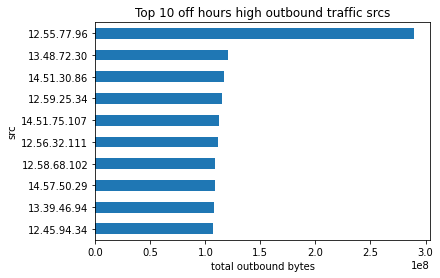

In [ ]:
off_hours_activity.head(10)\
    .sort_values()\
    .plot.barh(title='Top 10 off hours high outbound traffic srcs')\
    .set_xlabel('total outbound bytes')

Text(289566918.0, 40, '12.55.77.96')

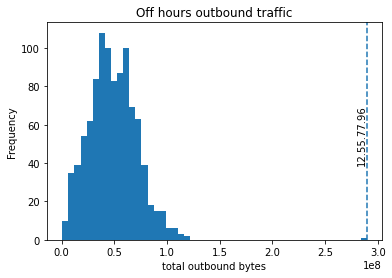

In [ ]:
ax = off_hours_activity.plot.hist(bins=50, title='Off hours outbound traffic')
ax.set_xlabel('total outbound bytes')
_ = ax.axvline(off_hours_activity.iloc[0], linestyle='--')
plt.text(off_hours_activity.iloc[0], 40, '12.55.77.96', rotation=90, horizontalalignment='right')

Looking only at off hour traffic is important because this might not be something that we would detect if we only looked at overall outbound traffic.[](http://)

Text(1033651932, 100, '12.55.77.96')

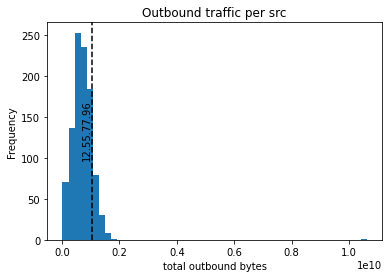

In [ ]:
ax = src_bytes_out\
  .plot.hist(bins=50, title='Outbound traffic per src')

ax.set_xlabel('total outbound bytes')
_ = ax.axvline(src_bytes_out.loc['12.55.77.96'], color='k', linestyle='--')
plt.text(src_bytes_out.loc['12.55.77.96'], 100, '12.55.77.96', rotation=90, horizontalalignment='right')

In [ ]:
blacklist_ips.append('12.55.77.96')
answers.append('12.55.77.96')

__ANSWER__: 12.55.77.96

### Question 3: Discover Data Exfiltration 3

*Some assailant is grabbing all the employee and vendor email addresses, and sending them out on a channel normally reserved for other uses. This is similar to attackers abusing DNS for data exfiltration. One host is sending out much more data on a some port from the enterprise than other hosts do, different from the hosts in Questions 1 and 2. What is its port?*


In [ ]:
src_port_bytes_df = df[
        ~df['src'].isin(blacklist_ips)     # Not including previous answers
        & df['src_int'] & ~df['dst_int']   # Outbound
    ].groupby(['src', 'port'])\
        .bytes.sum()\
        .reset_index()

ports = src_port_bytes_df['port'].unique()
print('Number of unique ports:', len(ports))

Number of unique ports: 46


For problems like this, we sometimes have some prior information/experience that can help us get started. Such as ports that we expect high bandwidth outbound traffic such as 443 and 80, and those that we don't expect high bandwidth traffic such as 53. There is also a notion of common and uncommonly used ports. However, looking at the data, it looks like none of that is applicable.

In [ ]:
src_port_bytes_df[src_port_bytes_df.port == 113]

,src,port,bytes


Text(0, 0.5, 'Total outbound bytes')

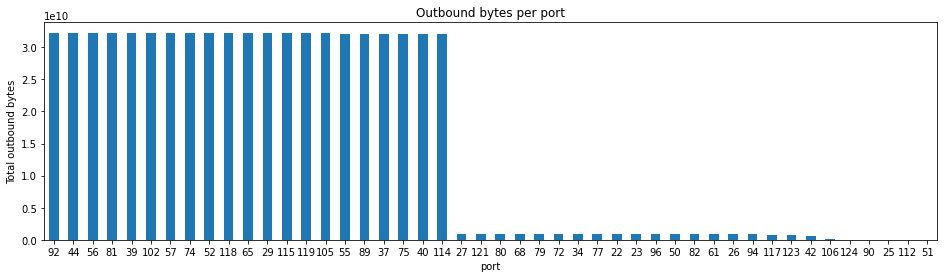

In [ ]:
src_port_bytes_df.groupby('port')\
    .bytes.sum()\
    .sort_values(ascending=False)\
    .plot.bar(figsize=(16,4), rot=0, title="Outbound bytes per port")\
    .set_ylabel('Total outbound bytes')

To look for atypical behavior on a particular port, we look for outliers in the univariate outbound traffic distributions for each port. After looking some of the distributions (such as for port 92 below), they look _bell-shaped_ so using the Z-score might be appropriate. However, if your find that the distributions are highly skewed, then you might want to do transformationm such as the _log transformation_, to make the distribution more _bell-shaped_.

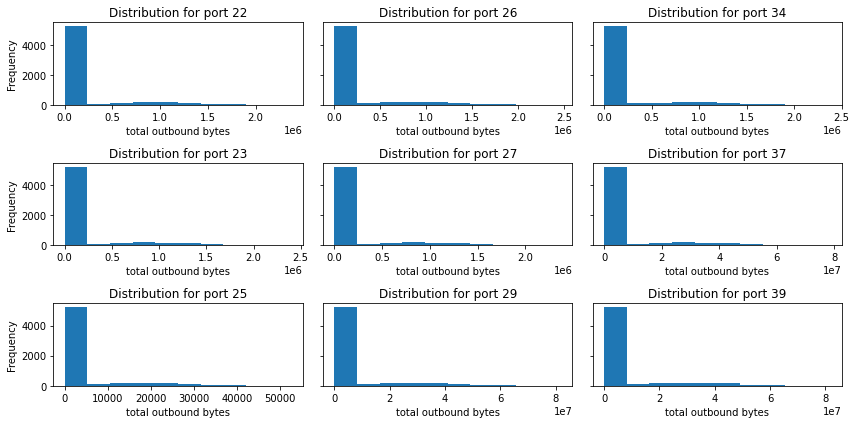

In [ ]:
fig, axs = plt.subplots(ncols=3, nrows=3, sharey=True, figsize=(12,6))

for idx, p in enumerate(src_port_bytes_df.port.head(9)):
    src_port_bytes_df[src_port_bytes_df.port == p]\
        .bytes.plot.hist(title='Distribution for port {}'.format(p), ax = axs[idx % 3][idx // 3])\
        .set_xlabel('total outbound bytes')

    plt.tight_layout()

We get the z-score of each `src` for each `port` and get the port with the highest z-score, which is probably the most anomalous port.

Text(0.5, 0, 'Max z-score')

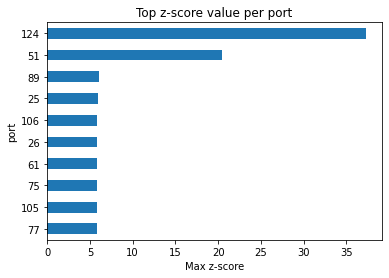

In [ ]:
src_port_bytes_df\
  .groupby('port')\
  .apply(lambda x: np.max((x.bytes - x.bytes.mean()) / x.bytes.std()))\
  .sort_values(ascending=True)\
  .tail(10)\
  .plot.barh(title='Top z-score value per port')\
  .set_xlabel('Max z-score')

In [ ]:
src_124 = src_port_bytes_df\
  .pipe(lambda x: x[x['port'] == 124])\
  .sort_values('bytes', ascending=False).head(1)

src_124

,src,port,bytes
35511,12.30.96.87,124,356207


Text(356207, 100, '12.30.96.87')

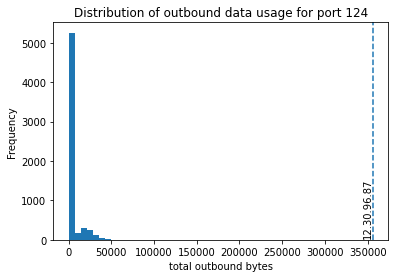

In [ ]:
ax = src_port_bytes_df[src_port_bytes_df.port == 124]\
    .bytes.plot.hist(bins=50, title='Distribution of outbound data usage for port 124')

ax.set_xlabel('total outbound bytes')
_ = ax.axvline(src_124.iloc[0, 2], linestyle='--')
plt.text(src_124.iloc[0, 2], 100, '12.30.96.87', rotation=90, horizontalalignment='right')

In [ ]:
blacklist_ips.append('12.30.96.87')
answers.append('124')

__ANSWER:__ 124

### Question 4: Private C&C channel

*We're always running a low-grade infection; some internal machines will always have some sort of malware. Some of these infected hosts phone home to C&C on a private channel. What unique port is used by external malware C&C to marshal its bots?*

We are looking at ports that are publicly accessible. If a public facing port is legitimate, which might mean it is part of typical business functions like a company website or corporate email server, then we would expect it to be used frequently and from many unique sources. 

In [ ]:
df[~df['src_int']]\
  .drop_duplicates(('src', 'port'))\
  .groupby('port').size()\
  .sort_values()\
  .head()

port
113       1
90     4898
124    4903
42     4903
123    4904
dtype: int64

In [ ]:
df[~df['src_int'] & (df['port'] == 113)][['src', 'dst', 'port']]

,src,dst,port
521102,15.104.76.58,12.45.104.32,113
8455407,15.104.76.58,12.54.109.102,113
10094539,15.104.76.58,12.44.90.114,113
14443401,15.104.76.58,13.46.43.95,113
16983637,15.104.76.58,14.41.54.105,113
20206697,15.104.76.58,14.40.73.39,113
22688529,15.104.76.58,13.34.88.95,113
23883204,15.104.76.58,13.43.104.74,113
28087392,15.104.76.58,12.33.73.55,113
29337718,15.104.76.58,13.34.89.21,113


In [ ]:
df[(df['src'] == '15.104.76.58') & (df['dst'] == '14.47.74.88')]\
    [['src', 'dst', 'port']]

,src,dst,port
7892499,15.104.76.58,14.47.74.88,105
8149894,15.104.76.58,14.47.74.88,114
16160969,15.104.76.58,14.47.74.88,118
26944990,15.104.76.58,14.47.74.88,52
31018365,15.104.76.58,14.47.74.88,105
31989255,15.104.76.58,14.47.74.88,105
40012898,15.104.76.58,14.47.74.88,39
52731269,15.104.76.58,14.47.74.88,115
78383054,15.104.76.58,14.47.74.88,115
91406004,15.104.76.58,14.47.74.88,115


In [ ]:
answers.append('113')

__ANSWER__: 113

### Question 5: Internal P2P

*Sometimes our low-grade infection is visible in other ways.  One particular virus has spread through a number of machines, which now are used to relay commands to each other.  The malware has created an internal P2P network.  What unique port is used by the largest internal clique, of all hosts talking to each other?*

This problem is pretty straightforward as well, since the question directly asks for _the largest clique_. There are methods to get the largest clique however due to the size of the graphs that we would end up constructing, these approaches may not be reasonable.  

To get the exact answer, then we can [enumerate all cliques](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.clique.find_cliques.html) and find the largest one. However this does not scale well. 

Instead, we can use an approximate method [max_clique(G)](https://networkx.github.io/documentation/networkx-1.9/reference/generated/networkx.algorithms.approximation.clique.max_clique.html). However, we opt to use the even faster [large_clique_size(G)](https://networkx.github.io/documentation/latest/reference/algorithms/generated/networkx.algorithms.approximation.clique.large_clique_size.html), which gives reasonable sizes in practice. 

In [ ]:
import networkx
from networkx.algorithms.approximation.clique import large_clique_size 
from collections import Counter

In [ ]:
internal_edges_all = df[
  df['src_int'] & df['dst_int']
].drop_duplicates(['src', 'dst', 'port'])
internal_ports = internal_edges_all.port.unique()

We can compute the result `large_clique_size` for each port within a "reasonable time" (maybe around half an hour). However, to further optimize our search, we get the upperbound of the maximum clique size for each graph.

It is easy to show that if a clique of size `K` exists inside graph `G`, then there should exist at least `K` nodes in `G` with degree greater than or equal to `K-1`. Given this fact, we can compute an upperbound for the clique size for each port. 

In [ ]:
port_upper_bounds = []
for p in internal_ports:
    internal_edges = internal_edges_all\
        .pipe(lambda x: x[x['port'] == p])\
        .drop_duplicates(['src', 'dst'])

    edges = set()
    for l, r in zip(internal_edges.src, internal_edges.dst):
        k = min((l, r), (r, l))
        edges.add(k)
    
    degrees = Counter()
    for (l, r) in edges:
        degrees[l] += 1
        degrees[r] += 1
    
    max_clique_size = 0
    min_degrees = len(degrees)
    for idx, (node, degree) in enumerate(degrees.most_common()):
        min_degrees = min(min_degrees, degree)
        if min_degrees >= idx:
            max_clique_size = max(max_clique_size, idx+1)
        if min_degrees < max_clique_size:
            break
            
    port_upper_bounds.append((p, max_clique_size + 1))

In [ ]:
port_upper_bounds.sort(key = lambda x: -x[-1])
port_upper_bounds[:5]

[(83, 264), (114, 204), (89, 204), (118, 204), (115, 204)]

We look for large cliques on ports with larger upperbounds. We can skip ports with upperbounds smaller than the largest clique size that we have already found.

In [ ]:
max_port = 0
curr_max_clique = 0
for p, max_clique_upper_bound in port_upper_bounds:
    if curr_max_clique > max_clique_upper_bound: break
    
    internal_edges = internal_edges_all\
        .pipe(lambda x: x[x['port'] == p])\
        .drop_duplicates(['src', 'dst'])
  
    internal_nodes = set(internal_edges.src) | set(internal_edges.dst)
    G = networkx.Graph()
    G.add_nodes_from(internal_nodes)
    for l, r in zip(internal_edges.src, internal_edges.dst):
        G.add_edge(l, r)        
        
    _size = large_clique_size(G) 
    if curr_max_clique < _size:
        curr_max_clique = _size
        max_port = p

In [ ]:
print('Port {} has approx. max clique size {}'.format(max_port, curr_max_clique))
answers.append(str(max_port))

Port 83 has approx. max clique size 264


__ANSWER:__ 83

### Question 6: Malware Controller

*We were just blacklisted by an IP reputation service, because some host in our network is behaving badly.  One host is a bot herder receiving C&C callbacks from its botnet, which has little other reason to communicate with hosts in the enterprise.  What is its IP?*

For this question, we just follow the clue _"which has little other reason to communicate with hosts in the enterprise"_. We look for external IPs that established a connection only to a single host.

In [ ]:
single_dst = df[~df['src_int'] & df['dst_int']]\
    .drop_duplicates(['src', 'dst'])\
    .src.value_counts()\
    .pipe(lambda x: x[x == 1])\
    .index

print('Count of "little reason" src:', len(single_dst))

Count of "little reason" src: 172


We simply ask, "_who are these external hosts talking to?_"

In [ ]:
df[~df['src_int'] & df['dst_int']]\
    .pipe(lambda x: x[x.src.isin(single_dst)])\
    .drop_duplicates(['src', 'dst'])\
    .groupby('dst').size()\
    .where(lambda x: x > 0).dropna()

dst
14.45.67.46    172.0
dtype: float64

In [ ]:
df[~df['src_int'] & df['dst_int']]\
  .pipe(lambda x: x[x.src.isin(single_dst)])\
  .drop_duplicates(['src', 'dst'])\
  .head()

,ts,src,dst,port,bytes,src_int,dst_int,hour,minute
14608703,2020-01-06 21:59:50.350,18.50.110.105,14.45.67.46,27,941,False,True,21,59
14611626,2020-01-06 21:59:54.799,19.125.42.108,14.45.67.46,27,877,False,True,21,59
14612006,2020-01-06 21:59:55.336,19.112.61.90,14.45.67.46,27,931,False,True,21,59
14612049,2020-01-06 21:59:55.401,15.67.125.70,14.45.67.46,27,1147,False,True,21,59
14612052,2020-01-06 21:59:55.401,19.92.34.40,14.45.67.46,27,913,False,True,21,59


In [ ]:
blacklist_ips.append('14.45.67.46')
answers.append('14.45.67.46')

__ANSWER__: 14.45.67.46

### Question 7: Infected Host

*One host is part of the botnet from Question 6, what is its IP?*

From the previous question we know that hosts in the botnet contact `14.45.67.46` on port `27`, so we look for internal hosts that have this similar behavior.

In [ ]:
df[
    df['src_int'] & df['dst_int']
    & (df['dst'] == '14.45.67.46')
    & (df['port'] == 27)
].drop_duplicates('src')

,ts,src,dst,port,bytes,src_int,dst_int,hour,minute
14623735,2020-01-06 22:00:12.552,14.51.84.50,14.45.67.46,27,902,True,True,22,0
62683179,2020-01-09 08:34:32.855,13.42.70.40,14.45.67.46,27,979,True,True,8,34


In [ ]:
blacklist_ips.append('14.51.84.50')
answers.append('14.51.84.50')

__ANSWER:__ 14.51.84.50

### Question 8: Botnet Inside
*There is a stealthier botnet in the network, using low frequency periodic callbacks to external C&C, with embedded higher frequency calls.  What port does it use?*

There are several ways to approach this challenge. The simplest and which has the strongest assumption, is we assume that the period is some nice number like _15 minutes_, _30 minutes_, or _60 minutes_. If so, then we should expect all connections to have a small number of distinct `minute`. For example, the connections might be established on `8:17`, `9:17`, `10:17`... 

In [ ]:
periodic_callbacks = df[df['src_int'] & ~df['dst_int']]\
  .drop_duplicates(['dst', 'minute'])\
  .groupby('dst').size()\
  .pipe(lambda x: x[(x > 0) & (x <= 4)])\
  .sort_values()

periodic_callbacks

dst
18.71.92.126     1
16.39.105.81     1
16.51.103.38     1
18.70.59.66      2
19.115.22.126    2
18.121.60.66     2
dtype: int64

And plotting connections to these hosts makes the periodicity very apparent, especially comparing it with the traffic to some benign 

<AxesSubplot:title={'center':'Connections over time to 14.53.122.55 (benign)'}, xlabel='ts'>

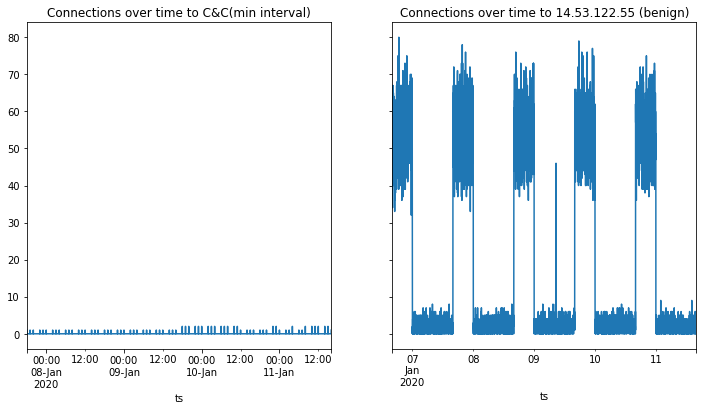

In [ ]:
fig, (ax_l, ax_r) = plt.subplots(ncols=2, sharey=True, figsize=(12,6))

df[df.dst.isin(periodic_callbacks.index)]\
    .set_index('ts')\
    .resample('Min').size()\
    .plot(title='Connections over time to C&C(min interval)', ax=ax_l)

df[df.dst == '14.53.122.55']\
    .set_index('ts')\
    .resample('Min').size()\
    .plot(title='Connections over time to 14.53.122.55 (benign)', ax=ax_r)

We were lucky with this problem, since this approach would not work if some jitter was introduced in the delay between callbacks. We would need to use a bit more sophisticated approaches to detect the beaconing.

In [ ]:
answers.append('51')

__ANSWER:__ 51

However for the sake of completeness, let's say that our initial attempt did not work because the beaconing was at a strange interval such as _17 minutes_.

In that case, we think about what other possible characteristics does beaconing have. If we assume that the callback occurs every _N seconds/minutes/hours_ with the same message (which is either something like "I'm alive!" or "What are my commands?"). Then we can look at 2 aspects
- The time difference between callbacks would be consistent
- The size (bytes) and duration of the connection would be consistent

It may also be that the callbacks that the botnet uses is some uncommon port, we can revisit the outbound ports used and _look at the long tail_.

Since this is a botnet that is contacting the C&C server, the time difference may not be as reliable, however, the size of the connections might be consistent. 

If we look for the the destinations that recieve consistent, connections sizes then we see that the hosts we identified earlier have 0 variance connection sizes. We see that callbacks are consistently `1337 bytes` large. 

In [ ]:
df[~df['dst_int']]\
    .groupby('dst')\
    .bytes.std()\
    .sort_values()\
    .head(10)

dst
16.51.103.38         0.000000
19.115.22.126        0.000000
18.121.60.66         0.000000
18.70.59.66          0.000000
16.39.105.81         0.000000
18.71.92.126         0.000000
17.110.95.63     24775.628446
19.22.108.42     24849.693691
16.114.59.36     24875.215356
17.60.68.45      24903.385372
Name: bytes, dtype: float64

We may also detected this if we investigated on outbound connections (or attempts to connect) to unknown or uncommon ports. As you can see, port `51` (and `31`) are have suspiciously low frequencies.

In [ ]:
df[~df['dst_int']]\
    .groupby('port').size()\
    .sort_values()\
    .head(10)

port
51        107
31        348
32       5564
78       5640
21       5671
95       5672
36       5778
123    481275
42     481672
112    481942
dtype: int64

In [ ]:
df.loc[
    df.dst.isin(periodic_callbacks.index),
    ['src', 'dst', 'bytes']
].head()

,src,dst,bytes
25974951,13.36.114.99,18.121.60.66,1337
28424761,13.36.114.99,18.121.60.66,1337
30876189,13.36.114.99,18.121.60.66,1337
35779858,12.48.48.60,19.115.22.126,1337
38226755,12.48.48.60,19.115.22.126,1337


And if we look at the time deltas of the connections of the botnet as a whole, we see that there is little variance around the 3 modes of the distributions might be the:
- connections that occurred at the same time
- low frequency callbacks
- high frequency callbacks 

<AxesSubplot:ylabel='Frequency'>

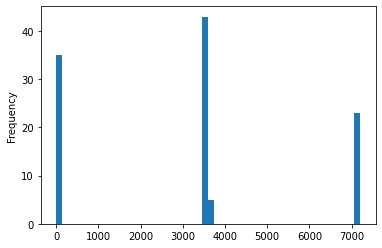

In [ ]:
df[df.dst.isin(periodic_callbacks.index)]\
    .ts.diff()\
    .dt.total_seconds()\
    .plot.hist(bins=50)

These are several characteristics that we can use to look for "weird" outbound connections

### Question 9: Lateral Brute

*Once a machine is popped, it's often used to explore what else can be reached.  One host is being used to loudly probe the entire enterprise, trying to find ways onto every other host in the enterprise.  What is its IP?*


Here we look for telltale signs of scanning which are one of:
- large number of distinct `destination ports` 
- large number of distinct `destination ips`

In [ ]:
dst_counts = df[df['src_int'] & df['dst_int']]\
    .drop_duplicates(['src', 'dst'])\
    .groupby('src').size()\
    .sort_values(ascending=False)
dst_counts.head()

NameError: name 'df' is not defined

Here it is clear that `13.42.70.40` is scanning and trying to move laterally. And for completeness, we can see a spike in network activity due to scanning on off hours.

<AxesSubplot:title={'center':'Network activity count of 13.42.70.40'}, xlabel='ts'>

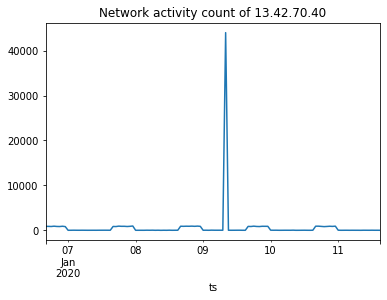

In [ ]:
df[df.src == '13.42.70.40']\
    .set_index('ts')\
    .resample('1h').size()\
    .plot(title='Network activity count of 13.42.70.40')

In [ ]:
blacklist_ips.append('13.42.70.40')
answers.append('13.42.70.40')

__ANSWER:__ 13.42.70.40

### Question 10: Lateral Spy

*One host is trying to find a way onto every other host more quietly.  What is its IP?*

In [ ]:
# Getting internal only connections
int_df = df[df['src_int'] & df['dst_int']]\
    .pipe(lambda x: x[~x.src.isin(blacklist_ips)])\
    .drop_duplicates(('src', 'dst', 'port'))

This is one of the trickier questions. Looking only at the number of unique `ports` or `dsts`, we cannot see any outliers.

In [ ]:
print('Unique dsts')
int_df\
  .drop_duplicates(['src', 'dst'])\
  .groupby('src').size()\
  .sort_values(ascending=False).head()

Unique dsts


src
14.34.65.37      417
14.57.111.109    417
14.41.31.49      417
13.43.77.101     417
13.36.43.78      417
dtype: int64

In [ ]:
print('Unique ports')
int_df\
  .drop_duplicates(['src', 'port'])\
  .groupby('src').size()\
  .sort_values(ascending=False).head()

Unique ports


src
14.34.65.37    46
12.45.54.25    46
14.41.31.49    46
13.36.43.78    46
13.53.79.40    46
dtype: int64

To move laterally, you may first have to identify hosts that are online, and which ports are open. And typically, hosts, such as desktops, shouldn't expect connections to a lot of its ports, especially those ports that are not used.

And for ports that are scanned, a lot of them may not be open, so we shouldn't expect legitimate traffic to try to connect to unused ports unless there is some misconfiguration misconfiguration. So for unused ports, we would only expect traffic from the scanner and no one else. 

For each `dst, port` pair, we collect the hosts that are connected to it. If a lot of hosts are observed to connect to it, then we are more confident that it is a legitimate `dst, port` pair.

In [ ]:
dst_port_df = int_df\
    .groupby(['dst', 'port'])\
    .src.apply(list).dropna()

dst_port_df.sample(10)

dst            port
13.42.66.93    22                                         [12.49.123.62]
13.46.80.34    94      [14.44.94.31, 14.46.36.121, 14.49.82.31, 13.36...
14.30.29.30    96                                         [12.49.123.62]
14.30.40.71    61                                         [12.49.123.62]
13.44.59.52    68      [12.34.57.42, 13.40.30.60, 13.59.54.25, 13.45....
13.41.114.96   82                                         [12.49.123.62]
13.57.106.78   61      [12.41.56.57, 13.58.54.65, 14.48.110.26, 14.43...
13.55.120.121  61      [13.30.49.24, 14.52.110.88, 12.44.73.26, 12.43...
12.36.36.112   37      [14.38.125.98, 14.51.39.122, 12.52.55.115, 14....
13.33.94.98    83      [12.45.52.97, 12.37.52.89, 14.48.110.26, 12.52...
Name: src, dtype: object

We filter out those that have only 1 unique `src` since these are more likely to be the result of some scanning. We then see where these activities come from.

In [ ]:
dst_port_df.pipe(lambda x: x[x.map(len) == 1])\
    .to_frame().reset_index()\
    .explode('src')\
    .src.value_counts()

12.49.123.62    5097
Name: src, dtype: int64

Here we see clearly that `12.49.123.62` is scanning the network.

In [ ]:
answers.append('12.49.123.62')

__ANSWER:__ 12.49.123.62

# Checking the answers

In [ ]:
import hashlib
answer_hash = hashlib.md5(':'.join(answers).encode('utf-8')).hexdigest()
assert answer_hash == 'ec766132cac80b821793fb9e7fdfd763'

In [ ]:
print('\n'.join(answers))

13.37.84.125
12.55.77.96
124
113
83
14.45.67.46
14.51.84.50
51
13.42.70.40
12.49.123.62


In [ ]:
print(blacklist_ips)

['13.37.84.125', '12.55.77.96', '12.30.96.87', '14.45.67.46', '14.51.84.50', '13.42.70.40']
